In [1]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, svm
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns
import os

from PIL import Image, ImageOps, ImageFilter
import numpy as np

from pathlib import Path
from typing import Iterable
import concurrent

from tqdm import tqdm


# Proyecto final

## Captcha solver

Para el proyecto presento un ejercicio de Ethical Hacking tratando de comprobar la seguridad que presenta la implementación de un captcha de texto en una página web.

En terminos generales un captcha de texto no es recomendable y no se considera un método seguro, este ejercicio pretende dar un fundamento para esta afirmación.

## Dataset

El dataset fue generado usando la librería de captchas de BotDetect(TM) CAPTCHA, y está compuesto por 5182 imagenes del captcha tipo "AncientMosaic" donde se agregó al nombre el código de texto.

La carga de infomración deberá interpretar esa información para poder generar las muestras y la variable dependiente.

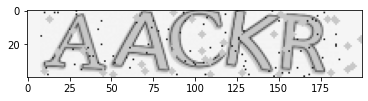

In [2]:
# ejemplo de las transformaciones
img = Image.open('entrenamiento/AncientMosaic--AACKR.png')
plt.imshow(img)

### Procesamiento de las imagenes

Durante la investigación para el entrenamiento de este modelo el procesamiento de la imagen que mejores resultados presentó es:

1. Pasar a grayscale
2. Aplicar gaussian blur
3. Reducir el tamaño a la mitad, alto de 20px
4. Centrar los datos pasando los rangos de [0,255] a [-1,1]
5. Aplanar los datos, de manera que pase de ser n*m a solo n

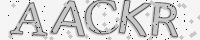

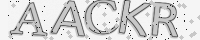

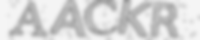

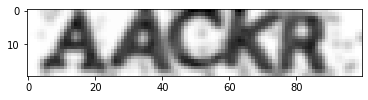

In [3]:
# ejemplo de las transformaciones
img = Image.open('entrenamiento/AncientMosaic--AACKR.png')

# grayscale
img2 = ImageOps.grayscale(img)  

# gaussian blur
img3 = img2.filter(ImageFilter.GaussianBlur(radius=2))

# reducir tamaño
img4 = img3.resize((int(img3.width/2), int(img3.height/2)))

# centrar
img5 = np.array(img4)
img5 = np.interp(img5, (img5.min(), img5.max()), (-1, +1))

display(img)
display(img2)
display(img3)
display(img4)
plt.imshow(img5, cmap='gray')




In [4]:
img2 = ImageOps.equalize(img2)

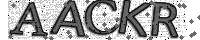

In [5]:
img2

In [9]:
def cut(img2, n=5):
    width = img2.width
    height = img2.height
    img2 = ImageOps.grayscale(img2)

    a = 0
    i = 0
    while a < 3:
        i += 1
        c = img2.crop((0, 0, i, img2.height))
        c = np.array(c)
        a = (c < 100).sum()
    pre = i

    a = 0
    i = 0
    while a < 3:
        i += 1
        c = img2.crop((img2.width - i, 0, img2.width, img2.height))
        c = np.array(c)
        a = (c < 100).sum()
    post = i

    # cortar la imagen
    img3 = img2.crop((pre, 0, img2.width - post, img2.height))
    img3 = img3.resize((width, height))
    # aplicar blur 
    img3 = img3.filter(ImageFilter.GaussianBlur(radius=2))
    # escalar a la mitad
    img3 = img3.resize((int(img3.width/2), int(img3.height/2)))

    images = []
    for i in range(n):
        img_i = img3.crop((i*img3.width/n, 0, (i+1)*img3.width/n, img3.height))
        images.append(img_i)
    return images

cut(img)

[<PIL.Image.Image image mode=L size=20x20 at 0x7FB25C56FEB0>,
 <PIL.Image.Image image mode=L size=20x20 at 0x7FB1B76A17E0>,
 <PIL.Image.Image image mode=L size=20x20 at 0x7FB1B76A1870>,
 <PIL.Image.Image image mode=L size=20x20 at 0x7FB1B76A1840>,
 <PIL.Image.Image image mode=L size=20x20 at 0x7FB1B76A3220>]

## Proceso de carga de las muestras

El proceso mostrado anteriormente se reproduce para todas las imagenes, ademas de cargar los textos a un arreglo para que nos sirva como variable Y.

En este caso no es necesario, y sería contraproducente usar pandas, todo el proceso se realiza usando unicamente arreglos de numpy.

Para poder realizar todo el proceso se crearon varias funciones que pueden procesar las imagenes en paralelo

In [10]:
# las imagenes estan en la carpeta imagenes, y tienen el nombre en formato tipo--texto.png
# ejemplo: AncientMosaic--RXWVJ.png
# debemos crear un dataset con el tipo de la imagen, el texto que contiene, la imagen y el texto resultante del OCR y si es correcto o no

# helper para obtener los archivos de una carpeta
def get_files(directory: Path) -> Iterable[Path]:
    """Devuelve el listado de archivos png que se encuentran en el directorio"""
    # Using glob simplifies the code in these cases.
    return (file for file in directory.glob("*.png") if file.is_file())

def transform_image(image: Image) -> np.ndarray:
    """aplica transformaciones a las imagenes de cada letra, asume que ya esta en blanco y negro"""
    # transformar a numpy array
    img = np.array(image)

    # convertir en unidimensional
    img = img.flatten()

    # escalar
    img = np.interp(img, (img.min(), img.max()), (-1, +1))

    return img

def get_images(file:Path, n:int=5) -> list: 
    """Funcion que abre una imagen, la procesa y genera 5 imagenes recortando cada letra"""

    # leer la imagen y transformarla a gris
    imagen = Image.open(file)
    # imagen = ImageOps.grayscale(imagen)

    # # aplicar filtro gaussiano
    # imagen = imagen.filter(ImageFilter.GaussianBlur(radius=3))

    # # escalarla a la mitad
    # imagen = imagen.resize((int(imagen.width/2), int(imagen.height/2)))

    # # Cortar la imagen en n caracteres:
    # # usualmente los captchas tienen un padding (margen interior)
    # # al rededor del texto, lo eliminaremos
    # padding = 8

    # # tambien agregamos un margen al rededor de cada caracter para
    # # garantizar que siempre tendremos el caracter dentro del recorte
    # margen = 4

    # # datos del tamaño de la imagen
    # imagen.size
    # length = imagen.size[0]
    # width = imagen.size[1]
    # crop_length = int((length - padding*2)/n)

    imagenes = []

    # recortamos todos los caracteres de la imagen
    for i in cut(imagen, n):
        imagenes.append(
            transform_image(i)
        )
    return imagenes

def get_caracteres(file: Path) -> list:
    """Funcion que obtiene el texto que contiene una imagen a partir de su nombre"""
    name = file.name
    # tipo = name.split('--')[0]
    texto = name.split('--')[1].split('.')[0]
    return [c for c in texto]

def procesar(file: Path) -> dict:
    """Funcion para procesas un archivo png y romperlo entre el texto que contiene"""
    # obtener los caracteres
    caracteres = get_caracteres(file)
    # obtener las imagenes
    imagenes = get_images(file, len(caracteres))
    
    return {'imagenes': imagenes, 'caracteres': caracteres}

def process_files(directory: Path) -> pd.DataFrame:
    """Funcion que procesa todos los archivos png de un directorio y los guarda en un array""" 

    # conteo total de archivos
    file_count = sum(1 for _ in get_files(directory))

    # devolveremos los datos en listas
    imagenes = []
    caracteres = []
    
    # concurrent permite ejecutar tareas en paralelo, reduciento bastante el tiempo de espera
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = executor.map(procesar, get_files(directory))
    
        # tqdm es una funcion que genera una barra de progres
        # asi sabemos en que paso va del total de imagenes.
        for result in tqdm(futures, total=file_count):

            # los resultados los agregamos a la lista correspondiente
            imagenes.extend(result['imagenes'])
            caracteres.extend(result['caracteres'])
    
    # se retorna toda la informacion para imagenes y caracteres, en arreglos numpy
    return {'imagen': np.array(imagenes), 'caracter': np.array(caracteres)}

df = process_files(Path('entrenamiento'))
df

100%|██████████| 5182/5182 [00:01<00:00, 4969.89it/s]


{'imagen': array([[1.        , 1.        , 0.93333333, ..., 1.        , 1.        ,
         1.        ],
        [0.61538462, 0.66666667, 0.82051282, ..., 0.79487179, 0.71794872,
         0.82051282],
        [0.68831169, 0.8961039 , 0.94805195, ..., 0.79220779, 0.42857143,
         0.03896104],
        ...,
        [0.44897959, 0.46938776, 0.69387755, ..., 0.85714286, 0.79591837,
         0.85714286],
        [0.85263158, 0.85263158, 0.83157895, ..., 0.76842105, 0.66315789,
         0.70526316],
        [0.825     , 0.8       , 0.8       , ..., 1.        , 0.975     ,
         0.975     ]]),
 'caracter': array(['A', 'C', 'H', ..., 'W', 'Y', 'J'], dtype='<U1')}

### Revision de los datos cargados

El resultado de la carga debe ser un arreglo numpy con 5182 arreglos de 400 valores (20x20px), que son las imagenes ya aplanadas


In [11]:
df['imagen'].shape

(25910, 400)

Podemos desplegar la informacion de un captcha leyendo 5 caracteres consecutivos:

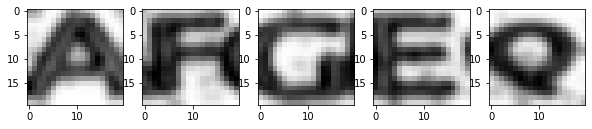

In [25]:
# helper para mostara una imagen desde los datos transformados a numpy
def show_img(flat_data):
    img = np.reshape(flat_data, (20, int(len(flat_data)/20)))
    plt.imshow(img, cmap='gray')
    plt.show()

# las imagenes deberian de ser de 44x40px
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))
for ax, image in zip(axes, df['imagen'][5:11]):
    # ax.set_axis_off()
    image = image.reshape(20, int(len(image)/20))
    ax.imshow(image, cmap=plt.cm.gray)


## Entrenamiento del modelo

Iniciamos por crear los datos de prueba y entrenamiento:

In [13]:
X = df['imagen']
y = df['caracter']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.6, stratify=y
)

El entrenamientod el modelo es bastante sencillo, como vems a continuacion

In [14]:
# clasificador es Support Vector Classifier, un algoritmo que en 
# SKlearn se puede usar con el método OnVsRestClassifier, lo que
# nos permite trabajar sobre los datos de entrenamiento en paralelo
# de toda la base de datos.
clf = OneVsRestClassifier(svm.SVC(gamma=0.015), n_jobs=12)

# Learn the digits on the train subset
clf.fit(X_train, y_train)


OneVsRestClassifier(estimator=SVC(gamma=0.015), n_jobs=12)

In [35]:
# import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = GridSearchCV(KNeighborsClassifier(cache_size=4096), param_grid={'n_neighbors': range(26, 100, 3)}, n_jobs=12)
clf.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=12,
             param_grid={'n_neighbors': range(26, 100, 3)})

Luego de entrenar el modelo, predecimos los datos de prueba para verificar la precisión:

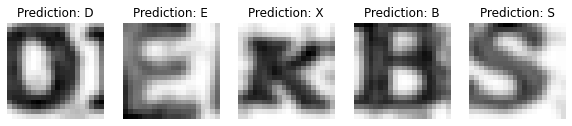

In [15]:
# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

# plot predictions
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(20, int(len(image)/20))
    ax.imshow(image, cmap=plt.cm.gray)
    ax.set_title(f"Prediction: {prediction}")

## Reporte de la clasificación:

In [17]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Classification report for classifier OneVsRestClassifier(estimator=SVC(gamma=0.015), n_jobs=12):
              precision    recall  f1-score   support

           A       0.97      0.98      0.97       579
           B       0.96      0.97      0.97       577
           C       0.94      0.96      0.95       601
           D       0.92      0.89      0.90       628
           E       0.97      0.95      0.96       585
           F       0.94      0.94      0.94       616
           G       0.97      0.94      0.95       579
           H       0.96      0.95      0.96       619
           I       0.76      0.79      0.77       585
           J       0.80      0.88      0.84       602
           K       0.91      0.92      0.91       591
           L       0.90      0.91      0.90       585
           M       0.94      0.95      0.95       590
           N       0.95      0.96      0.95       614
           O       0.90      0.80      0.84       600
           P       0.95      0.93     

### Matriz de confusion

Confusion matrix:
[[568   0   0   0   0   0   0   1   0   2   0   2   4   0   0   0   0   0
    0   0   2   0   0   0   0   0]
 [  0 560   0   0   2   0   0   0   5   1   1   0   2   2   0   0   0   1
    3   0   0   0   0   0   0   0]
 [  0   0 577   0   0   0   4   0   3   0   1   1   1   0  10   0   2   0
    0   2   0   0   0   0   0   0]
 [  0   1   1 561   1   0   0   2   6  11   0   0   1   0  32   0   3   0
    0   2   2   1   0   3   1   0]
 [  0   7   0   0 557   4   0   0   8   1   0   0   1   0   0   1   0   1
    2   0   1   0   0   0   1   1]
 [  0   1   0   0   1 576   0   3   9   0   0   0   0   0   0  13   1   5
    0   4   2   0   0   0   1   0]
 [  0   0   9   0   0   1 544   0   1   3   5   0   1   0   1   0   3   1
    7   0   0   0   1   1   0   1]
 [  0   0   0   0   1   7   0 589   2   2   1   1   1   5   0   0   0   2
    1   1   2   2   1   0   1   0]
 [  1   5   4   6   0   2   0   9 461  16   5  29   0   4   0   2   4   7
    2  16   8   0   0   2   0   2]
 

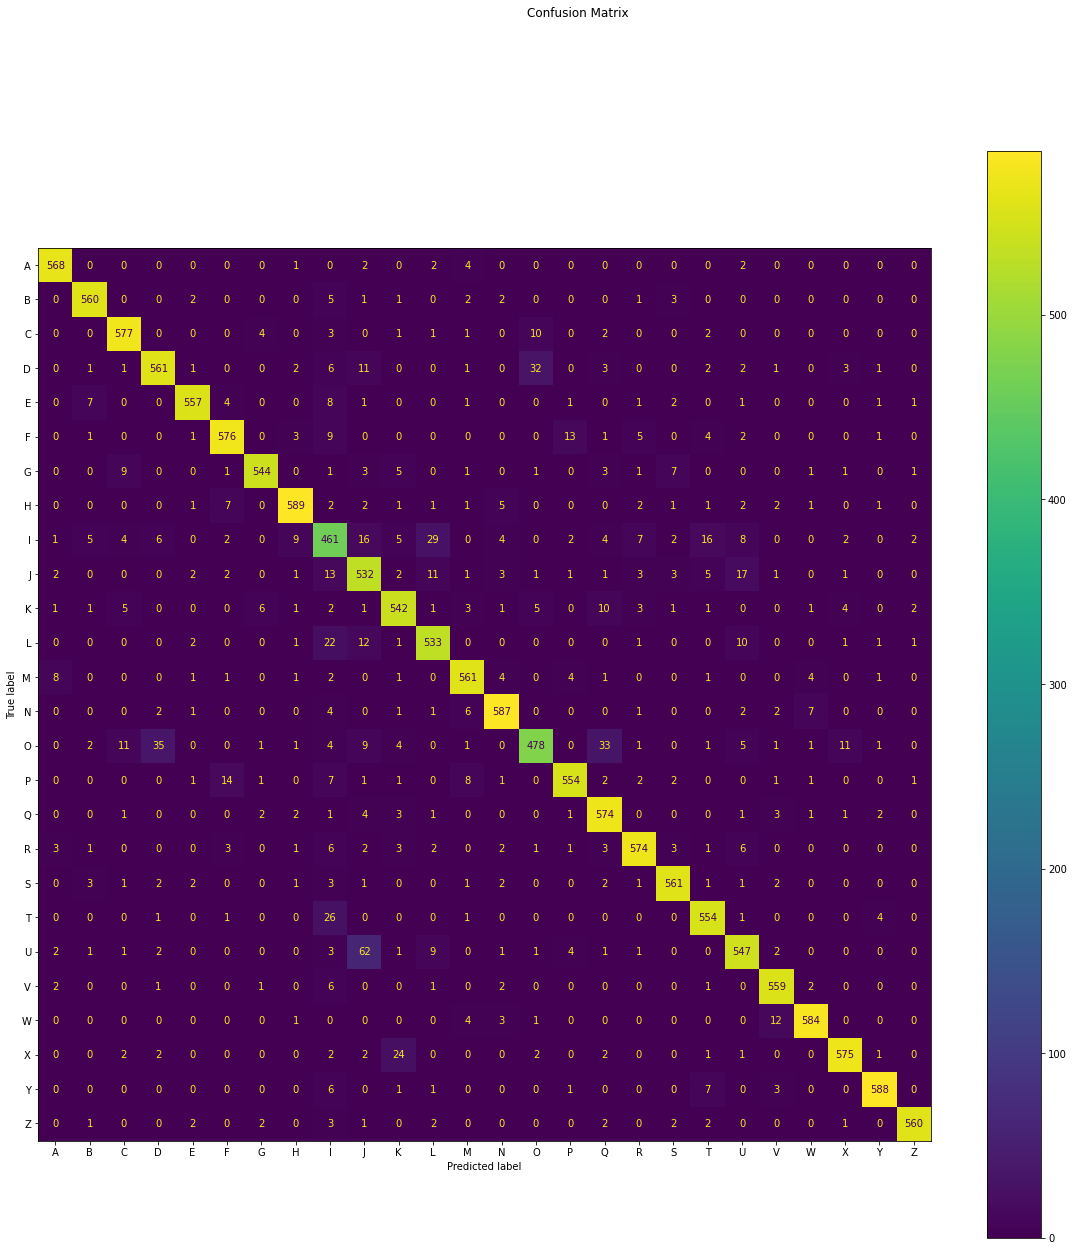

In [18]:
fig, ax = plt.subplots(figsize=(20,20))
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted, ax=ax)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

## Exportacion del modelo

El modelo se puede exportar par su posterior uso en producción, para esto es necesario guardarlo todo dentro de un objeto, para ello traducimos todo lo hecho hasta el momento a una clase:

In [22]:
class Clasificador(object):
    def __init__(self, clf=None, training=False):
        self.training = training
        self.clf = clf
        if not clf:
            self.training = True

    def transform_image(self, image: Image) -> np.ndarray:
        """aplica transformaciones a las imagenes de cada letra, asume que ya esta en blanco y negro"""
        # transformar a numpy array
        img = np.array(image)

        # convertir en unidimensional
        img = img.flatten()

        # escalar
        img = np.interp(img, (img.min(), img.max()), (-1, +1))

        return img

    def cut(self, img2, n=5):
        width = img2.width
        height = img2.height
        img2 = ImageOps.grayscale(img2)

        a = 0
        i = 0
        while a < 3:
            i += 1
            c = img2.crop((0, 0, i, img2.height))
            c = np.array(c)
            a = (c < 100).sum()
        pre = i

        a = 0
        i = 0
        while a < 3:
            i += 1
            c = img2.crop((img2.width - i, 0, img2.width, img2.height))
            c = np.array(c)
            a = (c < 100).sum()
        post = i

        # cortar la imagen
        img3 = img2.crop((pre, 0, img2.width - post, img2.height))
        img3 = img3.resize((width, height))
        # aplicar blur 
        img3 = img3.filter(ImageFilter.GaussianBlur(radius=2))
        # escalar a la mitad
        img3 = img3.resize((int(img3.width/2), int(img3.height/2)))

        images = []
        for i in range(n):
            img_i = img3.crop((i*img3.width/n, 0, (i+1)*img3.width/n, img3.height))
            images.append(img_i)
        return images


    def get_images(self, file:Path, n:int=5) -> list:
        # leer la imagen y transformarla a gris
        imagen = Image.open(file)
        # imagen = ImageOps.grayscale(imagen)

        # # aplicar filtro gaussiano
        # imagen = imagen.filter(ImageFilter.GaussianBlur(radius=3))

        # # escalarla a la mitad
        # imagen = imagen.resize((int(imagen.width/2), int(imagen.height/2)))

        # # Cortar la imagen en n caracteres:
        # # usualmente los captchas tienen un padding (margen interior)
        # # al rededor del texto, lo eliminaremos
        # padding = 8

        # # tambien agregamos un margen al rededor de cada caracter para
        # # garantizar que siempre tendremos el caracter dentro del recorte
        # margen = 4

        # # datos del tamaño de la imagen
        # imagen.size
        # length = imagen.size[0]
        # width = imagen.size[1]
        # crop_length = int((length - padding*2)/n)

        imagenes = []

        # recortamos todos los caracteres de la imagen
        for i in self.cut(imagen, n):
            imagenes.append(
                self.transform_image(i)
            )
        return imagenes

    def get_caracteres(self, file: Path) -> list:
        name = file.name
        # tipo = name.split('--')[0]
        texto = name.split('--')[1].split('.')[0]
        return [c for c in texto]

    def procesar(self, file: Path) -> dict:
        """Funcion para procesas un archivo png y romperlo entre el texto que contiene"""
        # obtener los caracteres
        caracteres = self.get_caracteres(file)
        # obtener las imagenes
        imagenes = self.get_images(file, len(caracteres))
        return {'imagenes': imagenes, 'caracteres': caracteres}

    def predict(self, img:Path):
        imagenes = self.get_images(img, 5)
        return self.clf.predict(imagenes)

La clase se debe instancia y asignar el modelo, luego de eso podemos predecir el texto a partir de cualquier imagen de muestra, como vemos a continuacion:

In [23]:
clf2 = Clasificador(clf=clf)
''.join(clf2.predict(Path('captcha.png')))

'EVJNR'

Se puede guardar el modelo mediante la librería joblib

In [24]:
from joblib import dump, load
dump(clf2, 'demo.joblib') 

['demo.joblib']